In [5]:
from math import degrees
from math import atan2
import torchvision

a = 400

def between_angles(y, x, theta1, theta2):
    return degrees(atan2(y, x)) >= theta1 and degrees(atan2(y, x)) <= theta2

def in_front(x, y):
    return x >= 0 and x <= a and degrees(atan2(y, x)) <= 35 and degrees(atan2(y, x)) >= -35

def in_front_left(x, y):
    if x == 0:
        return y >= 0
    
    return x <= a and y <= a and between_angles(y, x, 25, 95)

def in_front_right(x, y):
    if x == 0:
        return y <= 0
    
    return y <= 0 and degrees(atan2(y, x)) <= -25 and degrees(atan2(y, x)) >= -95

def in_back(x, y):
    return x <= 0 and (between_angles(y, x, 145, 180) or between_angles(y, x, -180, -145))

def in_back_left(x, y):
    if x == 0:
        return y >= 0
    
    return y >= 0 and between_angles(y, x, 85, 155)

def in_back_right(x, y):
    if x == 0:
        return y <= 0
    
    return y <= 0 and between_angles(y, x, -155, -85)

In [7]:
from PIL import Image

def convert_map_to_road_map(ego_map):
    mask = (ego_map[0,:,:] == 1) * (ego_map[1,:,:] == 1) * (ego_map[2,:,:] == 1)

    return (~mask)

def get_color(x):
    if x == 1:
        return 255
    
    return 0

im = Image.open('/Users/nikhilvs/repos/nyu/vehicle-scene-generator/data/scene_108/sample_86/ego.png')

out = Image.new('RGB', im.size, (0, 0, 0))

width, height = im.size
for x in range(width):
    for y in range(height):
        r,g,b = im.getpixel((x,y))
        if in_back_right(x - a, -y + a):
            out.putpixel((x, y), (r, g, b))


ego_image = torchvision.transforms.functional.to_tensor(im)
road_image = convert_map_to_road_map(ego_image)

im = torchvision.transforms.ToPILImage(mode = None)(road_image.int())
front = Image.new('L', im.size, 100)
front_left = Image.new('L', im.size, 100)
front_right = Image.new('L', im.size, 100)
back = Image.new('L', im.size, 100)
back_left = Image.new('L', im.size, 100)
back_right = Image.new('L', im.size, 100)

width, height = im.size
for x in range(width):
    for y in range(height):
        c = im.getpixel((x,y))
        if in_front(x - a, -y + a):
            front.putpixel((x, y), get_color(c))
        if in_front_left(x - a, -y + a):
            front_left.putpixel((x, y), get_color(c))
        if in_front_right(x - a, -y + a):
            front_right.putpixel((x, y), get_color(c))
        if in_back(x - a, -y + a):
            back.putpixel((x, y), get_color(c))
        if in_back_left(x - a, -y + a):
            back_left.putpixel((x, y), get_color(c))
        if in_back_right(x - a, -y + a):
            back_right.putpixel((x, y), get_color(c))

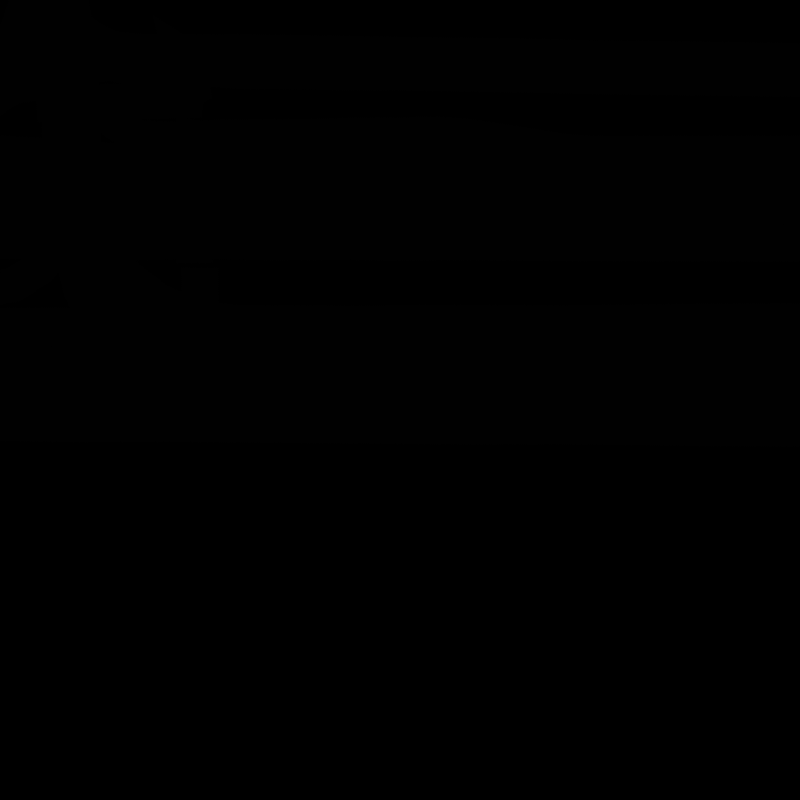

In [20]:
i = road_image.int()
i[i == 1] = 255
torchvision.transforms.ToPILImage(mode = None)(i)

# torchvision.transforms.ToPILImage(mode = None)(road_image.int())

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from PIL import Image
from helper import convert_map_to_road_map, convert_map_to_lane_map

import multiprocessing
from joblib import Parallel, delayed

def get_color(x):
    if x == 1:
        return 255
    
    return 0

def generate_image(i, j):
    ego_path = '/Users/nikhilvs/repos/nyu/vehicle-scene-generator/data/scene_' + str(i) + '/sample_' + str(j) + '/ego.png'
    ego_image_1 = Image.open(ego_path)
    ego_image = torchvision.transforms.functional.to_tensor(ego_image_1)
    road_image = convert_map_to_road_map(ego_image)

    im = torchvision.transforms.ToPILImage(mode = None)(road_image.int())
    front = Image.new('L', im.size, 100)
    front_left = Image.new('L', im.size, 100)
    front_right = Image.new('L', im.size, 100)
    back = Image.new('L', im.size, 100)
    back_left = Image.new('L', im.size, 100)
    back_right = Image.new('L', im.size, 100)

    width, height = im.size
    for x in range(width):
        for y in range(height):
            c = im.getpixel((x,y))
            if in_front(x - a, -y + a):
                front.putpixel((x, y), get_color(c))
            if in_front_left(x - a, -y + a):
                front_left.putpixel((x, y), get_color(c))
            if in_front_right(x - a, -y + a):
                front_right.putpixel((x, y), get_color(c))
            if in_back(x - a, -y + a):
                back.putpixel((x, y), get_color(c))
            if in_back_left(x - a, -y + a):
                back_left.putpixel((x, y), get_color(c))
            if in_back_right(x - a, -y + a):
                back_right.putpixel((x, y), get_color(c))
    
    front = front.resize((128, 128), Image.ANTIALIAS)
    front_left = front_left.resize((128, 128), Image.ANTIALIAS)
    front_right = front_right.resize((128, 128), Image.ANTIALIAS)
    back = back.resize((128, 128), Image.ANTIALIAS)
    back_left = back_left.resize((128, 128), Image.ANTIALIAS)
    back_right = back_right.resize((128, 128), Image.ANTIALIAS)
    
    front.save('/Users/nikhilvs/repos/nyu/vehicle-scene-generator/parts_data/' + str(i) + '_' + str(j) + '_front.png')
    front_left.save('/Users/nikhilvs/repos/nyu/vehicle-scene-generator/parts_data/' + str(i) + '_' + str(j) + '_front_left.png')
    front_right.save('/Users/nikhilvs/repos/nyu/vehicle-scene-generator/parts_data/' + str(i) + '_' + str(j) + '_front_right.png')
    back.save('/Users/nikhilvs/repos/nyu/vehicle-scene-generator/parts_data/' + str(i) + '_' + str(j) + '_back.png')
    back_left.save('/Users/nikhilvs/repos/nyu/vehicle-scene-generator/parts_data/' + str(i) + '_' + str(j) + '_back_left.png')
    back_right.save('/Users/nikhilvs/repos/nyu/vehicle-scene-generator/parts_data/' + str(i) + '_' + str(j) + '_back_right.png')


x = list(range(106, 134))
y = list(range(126))
z = [(i, j) for i in x for j in y]

Parallel(n_jobs = 8)(delayed(generate_image)(i, j) for (i, j) in z)

ModuleNotFoundError: No module named 'helper'

In [139]:
out.save('/Users/nikhilvs/repos/nyu/vehicle-scene-generator/parts_data/part_0_0.png')

In [84]:
out = Image.new('RGB', im.size, (0, 0, 0))
width, height = im.size
for x in range(width):
    for y in range(height):
        r,g,b = im.getpixel((x,y))
        if in_front_left(x - a, -y + a):
            out.putpixel((x, y), (r, g, b))

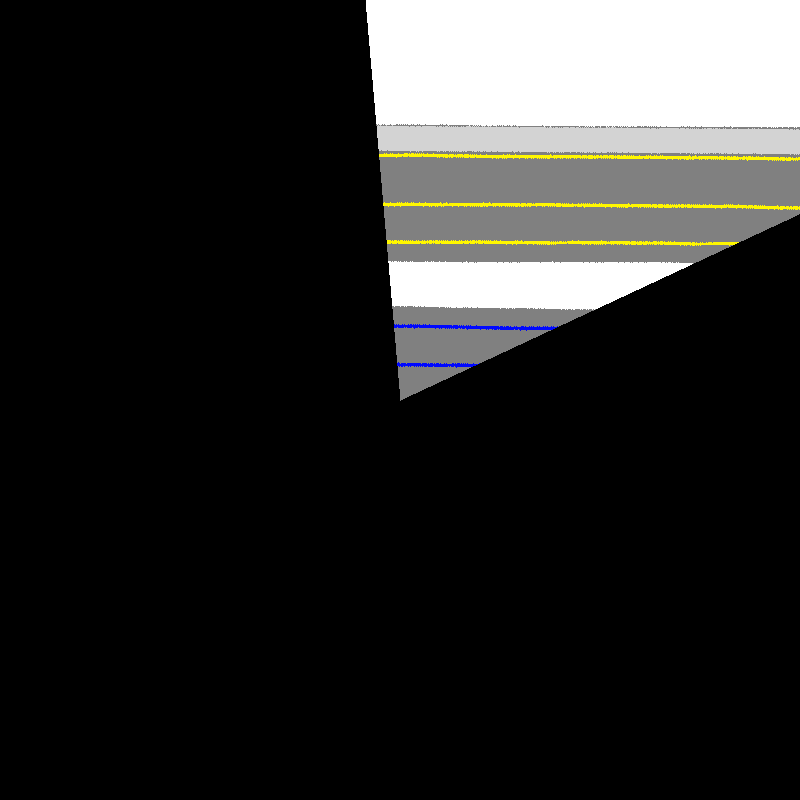

In [85]:
out

In [165]:
ego_path = '/Users/nikhilvs/repos/nyu/vehicle-scene-generator/data/scene_' + str(107) + '/sample_' + str(81) + '/ego.png'
ego_image_1 = Image.open(ego_path)
ego_image = torchvision.transforms.functional.to_tensor(ego_image_1)
road_image = convert_map_to_road_map(ego_image)

im = torchvision.transforms.ToPILImage(mode = None)(road_image.int())
front_1 = Image.new('L', im.size, 100)

width, height = im.size
for x in range(width):
    for y in range(height):
        c = im.getpixel((x,y))
        if in_front(x - a, -y + a):
            front_1.putpixel((x, y), get_color(c))

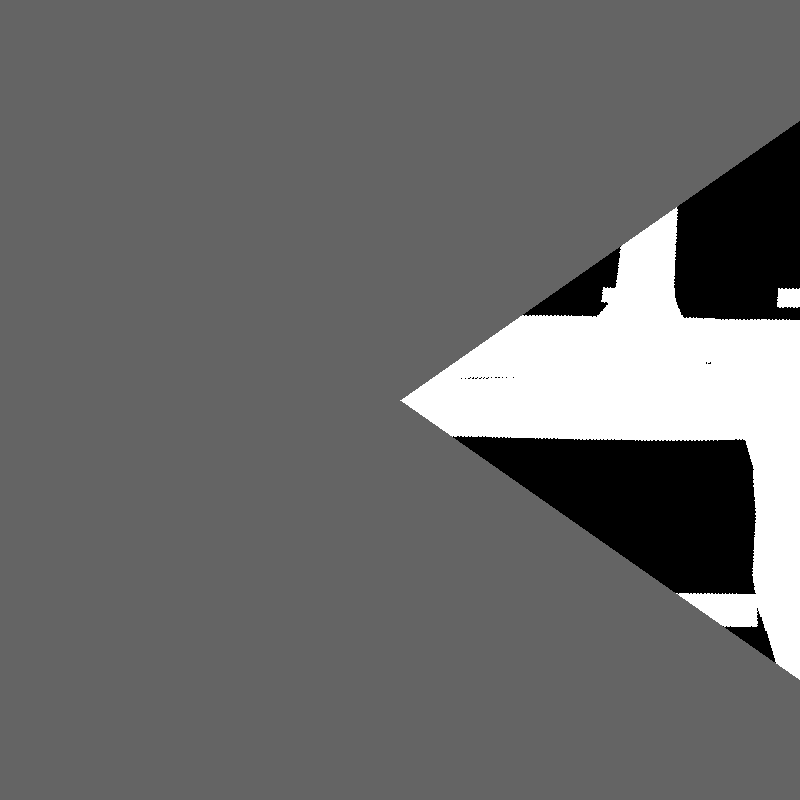

In [166]:
front_1

In [167]:
front = front_1.resize((100, 100), Image.ANTIALIAS)
front.save('/Users/nikhilvs/temp/img/' + str(107) + '_' + str(81) + '_front_100.png')

In [168]:
front = front_1.resize((128, 128), Image.ANTIALIAS)
front.save('/Users/nikhilvs/temp/img/' + str(107) + '_' + str(81) + '_front_128.png')